In [462]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [463]:
wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
tf_columns = ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']

def _load_wrench(scene, fc):
    wrench_path = os.path.join(data_path, scene, 'wrenches', scene, 'wrenches', '{}_wrench_{:06d}.csv'.format(scene, fc))
    wrench_df = pd.read_csv(wrench_path)
    return wrench_df

def load_wrench(scene, fc, frame_id='med_base'):
    wrench_df = _load_wrench(scene, fc)
    wrench_in_frame = wrench_df[wrench_df['header.frame_id']==frame_id]
    wrench = wrench_in_frame[wrench_columns]
    return wrench.values

def _load_tf(scene, fc):
    tf_path = os.path.join(data_path, scene, 'tfs', 'recorded_tfs_{:06d}.csv'.format(fc))
    tf_df = pd.read_csv(tf_path)
    return tf_df

def load_tf(scene, fc, frame_id='grasp_frame', ref_id='med_base'):
    tf_df = _load_tf(scene, fc)
    tf_df_frame = tf_df[tf_df['parent_frame'] == ref_id]
    tf_df_frame = tf_df_frame[tf_df_frame['child_frame'] == frame_id]
    tf_i = tf_df_frame[tf_columns]
    return tf_i.values

def add_wrenches_and_tfs(df):
    df_out = df.copy()
    wrenches = []
    tfs = []
    for i, row_i in df_out.iterrows():
        wrench_i = load_wrench(row_i['Scene'], row_i['FileCode'])
        tf_i = load_tf(row_i['Scene'], row_i['FileCode'])
        wrenches.append(wrench_i)
        tfs.append(tf_i)
    wrenches = np.concatenate(wrenches, axis=0)
    tfs = np.concatenate(tfs, axis=0)
    wrenches_df = pd.DataFrame(wrenches, columns=wrench_columns)
    tfs_df = pd.DataFrame(tfs, columns=tf_columns)
    df_out = pd.concat([df_out, wrenches_df, tfs_df], axis=1)
    return df_out

def _load_img(scene, fc):
    img_path = os.path.join(data_path, scene, 'camera_1', 'color_data', '{}_color_{:06d}.png'.format(scene, fc))
#     img = cv2.imread(img_path)
    img = plt.imread(img_path)
    return img



In [464]:
img = _load_img('bubbles', 1)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mmint/Desktop/bubble_vs_gelsight_sideways_calibration_data/bubbles/camera_1/color_data/bubbles_color_000001.png'

# TOP DOWN CONTACT EVALUATION

In [465]:
data_dir = '/home/mmint/Desktop'
data_name = 'bubble_vs_gelsight_calibration_data'
data_path = os.path.join(data_dir, data_name)

dl_path = os.path.join(data_path, '{}_DataLegend.csv'.format(data_name))
dl = pd.read_csv(dl_path)
dl

,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState
0,1.650380e+09,bubbles,bubbles,0,0,1,"(0.541192916079795, 0.7260528808322005, -0.911..."
1,1.650380e+09,bubbles,bubbles,0,1,2,"(0.5415955860093442, 0.7271257686482389, -0.91..."
2,1.650380e+09,bubbles,bubbles,0,2,3,"(0.5421308014782776, 0.7289304730196384, -0.91..."
3,1.650380e+09,bubbles,bubbles,0,3,4,"(0.5429740714871788, 0.7325497688344836, -0.91..."
4,1.650380e+09,bubbles,bubbles,0,4,5,"(0.5438358570396161, 0.7364136627265189, -0.91..."
...,...,...,...,...,...,...,...
259,1.650384e+09,gelsight,gelsight,5,35,260,"(0.563842442009601, 0.9512552221460809, -0.937..."
260,1.650384e+09,gelsight,gelsight,5,36,261,"(0.5661061422306685, 0.9546822909968533, -0.94..."
261,1.650384e+09,gelsight,gelsight,5,37,262,"(0.5682487419089217, 0.9579092832652415, -0.94..."
262,1.650384e+09,gelsight,gelsight,5,38,263,"(0.5703340569358814, 0.9609349405688554, -0.95..."


In [466]:
df_out = add_wrenches_and_tfs(dl)
df_out['Sensor_Seq'] = df_out['SensorName'] + '_' + df_out['Sequence'].astype(str)

In [467]:
# SIDEWAYS:
x_key = 'z'
y_key = 'wrench.force.z'

x_range_ss = [0.12,0.22]
x_range = [0, 0.12]

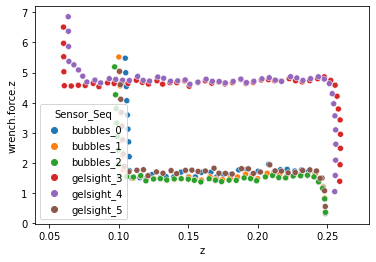

In [468]:
sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [469]:
steady_data = df_out[(df_out[x_key] < x_range_ss[1]) & (df_out[x_key] > x_range_ss[0]) ]

unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
means = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_ss = steady_data[steady_data.Sensor_Seq == sensor_seq_i] 
    means[sensor_seq_i] = np.mean(sensor_ss[y_key])

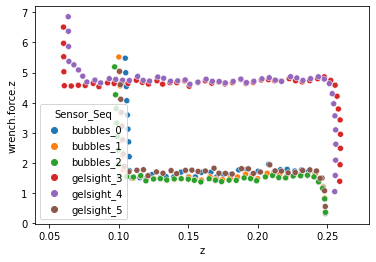

In [470]:
ax = sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [471]:
df_out['steady_value'] = df_out['Sensor_Seq'].map(means)
df_out['{}_norm'.format(y_key)] = -df_out['steady_value'] + df_out[y_key]

# df_norm = df_out[(df_out[x_key] < x_range[1]) & (df_out[x_key] > x_range[0]) ]


x_elbow_map_pre = {'bubbles': 0.11, 'gelsight':0.065}
df_out['x_elbow'] = df_out['SensorName'].map(x_elbow_map_pre)
df_out['{}_norm'.format(x_key)] = -df_out[x_key] + df_out['x_elbow']



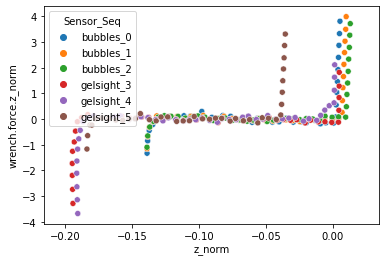

In [472]:
ax = sns.scatterplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_out, hue='Sensor_Seq')

In [473]:
# # ESTIMATE ELBOWs:
unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
x_elbow_map = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_seq_df = df_out[df_out.Sensor_Seq == sensor_seq_i]
    sensor_seq_df = sensor_seq_df[sensor_seq_df['{}_norm'.format(x_key)] > -0.03]
    sensor_seq_df = sensor_seq_df[sensor_seq_df['{}_norm'.format(y_key)] > 0.58]
    sensor_seq_data = sensor_seq_df['{}_norm'.format(y_key)]
    if len(sensor_seq_data) > 0:
        elbow_value_i = sensor_seq_df['{}_norm'.format(x_key)].iloc[np.argmin(sensor_seq_data)]
    #     import pdb; pdb.set_trace()
        x_elbow_map[sensor_seq_i] = elbow_value_i
    else:
        x_elbow_map[sensor_seq_i] = 0

    
df_out['x_elbow'] = df_out['Sensor_Seq'].map(x_elbow_map)
df_out['{}_norm'.format(x_key)] = df_out['{}_norm'.format(x_key)] - df_out['x_elbow']


df_norm_filtered = df_out[df_out['{}_norm'.format(x_key)] > 0]

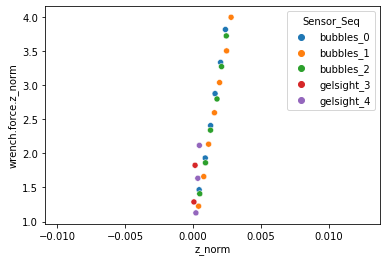

In [474]:
ax = sns.scatterplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_norm_filtered, hue='Sensor_Seq')

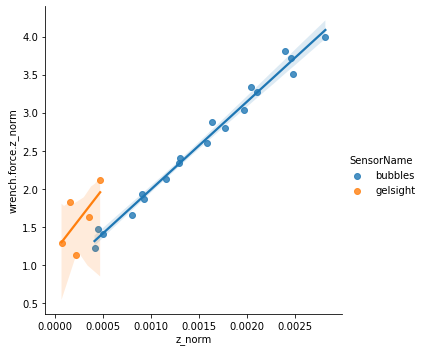

In [475]:
ax = sns.lmplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_norm_filtered, hue='SensorName')

In [478]:
def regression_plots(df, keys, x_range, label_map=None):
    regressions = {}
    xs = np.linspace(0, x_range, 100)
    palette = sns.color_palette('tab10')
    fig, ax = plt.subplots()
    for i, key in enumerate(keys):
        raw_data = df[df['Sensor_Seq'] == key]
        force_data = np.stack([raw_data['{}_norm'.format(x_key)].values, raw_data['{}_norm'.format(y_key)].values], axis=0) # x, y
        reg_i = LinearRegression().fit(force_data[0:1].T, force_data[1:2].T)
        regressions[key] = reg_i
        # plot
        color_i = palette[i]
        ys = reg_i.predict(xs[:,None])
        label_i = key
        if label_map is not None:
            label_i = label_map[key]
        ax.plot(xs,ys-reg_i.intercept_[0], color=color_i, label=label_i)
        ax.scatter(force_data[0], force_data[1]-reg_i.intercept_[0], marker='o', color=color_i)
        
        plt.legend()
    return ax, regressions

gelsight_4 [[3867.3866968]] [0.27450255]
bubbles_1 [[1131.96325974]] [0.78046427]


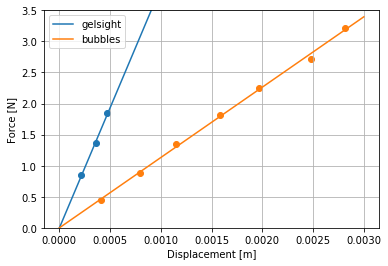

In [479]:
ax, regs = regression_plots(df_norm_filtered, ['gelsight_4', 'bubbles_1'], 0.003, label_map={'gelsight_4':'gelsight', 'bubbles_1':'bubbles'})
ax.set_ylim([0,3.5])
ax.set_xlabel('Displacement [m]')
ax.set_ylabel('Force [N]')
ax.grid()
for k, reg_i in regs.items():
    print(k, reg_i.coef_, reg_i.intercept_)

In [483]:
# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight.svg'))


# SIDEWAYS CONTACT EVALUATION:

In [485]:
data_dir = '/home/mmint/Desktop'
data_name = 'bubble_vs_gelsight_sideways_calibration_data'
data_path = os.path.join(data_dir, data_name)

dl_path = os.path.join(data_path, '{}_DataLegend.csv'.format(data_name))
dl = pd.read_csv(dl_path)
dl

,Unnamed: 0,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState
0,0,1.650387e+09,gelsight,bubbles,0,0,1,"(-0.43475813847793715, 0.7157415938574748, -0...."
1,1,1.650387e+09,gelsight,bubbles,0,1,2,"(-0.4210751496232172, 0.706530518591809, -0.08..."
2,2,1.650387e+09,gelsight,bubbles,0,2,3,"(-0.40590006493741626, 0.6968202404355799, -0...."
3,3,1.650387e+09,gelsight,bubbles,0,3,4,"(-0.3904033835928982, 0.6876256434778806, -0.0..."
4,4,1.650387e+09,gelsight,bubbles,0,4,5,"(-0.3754515650247541, 0.6791338613756944, -0.0..."
...,...,...,...,...,...,...,...,...
217,217,1.650390e+09,gelsight,gelsight,6,13,218,"(-0.048146503738030685, 0.630390003974953, -0...."
218,218,1.650390e+09,gelsight,gelsight,6,14,219,"(-0.021641772492455143, 0.6263002674229529, -0..."
219,219,1.650390e+09,gelsight,gelsight,6,15,220,"(0.005682380146790066, 0.6232424324656677, -0...."
220,220,1.650390e+09,gelsight,gelsight,6,16,221,"(0.0289447793160984, 0.6208860343173683, -0.15..."


In [486]:
df_out = add_wrenches_and_tfs(dl)
df_out['Sensor_Seq'] = df_out['SensorName'] + '_' + df_out['Sequence'].astype(str)
df_out

,Unnamed: 0,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState,wrench.force.x,wrench.force.y,...,wrench.torque.y,wrench.torque.z,x,y,z,qx,qy,qz,qw,Sensor_Seq
0,0,1.650387e+09,gelsight,bubbles,0,0,1,"(-0.43475813847793715, 0.7157415938574748, -0....",0.679899,-0.942702,...,0.290164,0.044782,0.549554,-0.291057,0.150289,-0.707164,0.707048,0.001456,0.000798,bubbles_0
1,1,1.650387e+09,gelsight,bubbles,0,1,2,"(-0.4210751496232172, 0.706530518591809, -0.08...",0.796776,-1.136427,...,0.264012,0.002117,0.549602,-0.281348,0.150259,-0.707111,0.707100,0.001646,0.001023,bubbles_0
2,2,1.650387e+09,gelsight,bubbles,0,2,3,"(-0.40590006493741626, 0.6968202404355799, -0....",0.616799,-1.038514,...,0.221504,0.015620,0.549591,-0.271126,0.150258,-0.707125,0.707085,0.001623,0.001102,bubbles_0
3,3,1.650387e+09,gelsight,bubbles,0,3,4,"(-0.3904033835928982, 0.6876256434778806, -0.0...",0.706146,-0.969429,...,0.241389,-0.007964,0.549595,-0.260938,0.150262,-0.707098,0.707113,0.001655,0.001088,bubbles_0
4,4,1.650387e+09,gelsight,bubbles,0,4,5,"(-0.3754515650247541, 0.6791338613756944, -0.0...",0.849489,-1.057702,...,0.269867,0.001145,0.549607,-0.251092,0.150276,-0.707109,0.707102,0.001756,0.001120,bubbles_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,217,1.650390e+09,gelsight,gelsight,6,13,218,"(-0.048146503738030685, 0.630390003974953, -0....",2.417351,-1.257302,...,0.584721,0.215882,0.549657,-0.088886,0.121001,0.707191,-0.707020,-0.001916,-0.000350,gelsight_6
218,218,1.650390e+09,gelsight,gelsight,6,14,219,"(-0.021641772492455143, 0.6263002674229529, -0...",2.349683,0.040226,...,0.666500,0.013921,0.549623,-0.074209,0.121002,0.707076,-0.707135,-0.001922,-0.000308,gelsight_6
219,219,1.650390e+09,gelsight,gelsight,6,15,220,"(0.005682380146790066, 0.6232424324656677, -0....",3.038315,0.097946,...,0.791158,0.018574,0.549677,-0.059123,0.120986,0.707085,-0.707126,-0.002073,-0.000176,gelsight_6
220,220,1.650390e+09,gelsight,gelsight,6,16,221,"(0.0289447793160984, 0.6208860343173683, -0.15...",3.005981,-1.228559,...,0.738814,0.042937,0.549632,-0.047197,0.121007,0.707258,-0.706954,-0.001180,0.000800,gelsight_6


In [487]:
df_out[df_out.Sensor_Seq == 'bubbles_1']

,Unnamed: 0,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState,wrench.force.x,wrench.force.y,...,wrench.torque.y,wrench.torque.z,x,y,z,qx,qy,qz,qw,Sensor_Seq
29,29,1.650388e+09,gelsight,bubbles,1,0,30,"(-0.40677491340664, 0.7156585431286003, -0.126...",-0.156045,-0.237119,...,0.116759,0.037654,0.549516,-0.289604,0.150344,-0.707154,0.707058,0.001282,0.001019,bubbles_1
30,30,1.650388e+09,gelsight,bubbles,1,1,31,"(-0.39388372229226915, 0.7073692944869695, -0....",0.286547,-0.867051,...,0.165223,0.066865,0.549572,-0.280737,0.150360,-0.707185,0.707026,0.001525,0.001136,bubbles_1
31,31,1.650388e+09,gelsight,bubbles,1,2,32,"(-0.37747570058911134, 0.697327233057844, -0.1...",0.188751,-0.545337,...,0.166916,0.032063,0.549546,-0.270143,0.150335,-0.707146,0.707066,0.001433,0.001053,bubbles_1
32,32,1.650388e+09,gelsight,bubbles,1,3,33,"(-0.3622199020612211, 0.6885836624491989, -0.1...",0.411184,-0.619078,...,0.208487,0.009921,0.549566,-0.260287,0.150323,-0.707117,0.707094,0.001516,0.001022,bubbles_1
33,33,1.650388e+09,gelsight,bubbles,1,4,34,"(-0.34689944879293855, 0.6799903140746022, -0....",0.418932,-0.677048,...,0.212194,0.005826,0.549565,-0.250413,0.150350,-0.707114,0.707097,0.001581,0.001082,bubbles_1
34,34,1.650388e+09,gelsight,bubbles,1,5,35,"(-0.3308821726026311, 0.6714917009718897, -0.1...",0.349178,-0.634305,...,0.191701,0.004307,0.549559,-0.240306,0.150322,-0.707112,0.707099,0.001553,0.001103,bubbles_1
35,35,1.650388e+09,gelsight,bubbles,1,6,36,"(-0.31485896436544536, 0.6634972042979173, -0....",0.448172,-0.629966,...,0.195458,0.007828,0.549578,-0.230314,0.150319,-0.707120,0.707091,0.001566,0.001110,bubbles_1
36,36,1.650388e+09,gelsight,bubbles,1,7,37,"(-0.2989481080991151, 0.6560645880150239, -0.1...",0.643658,-0.742740,...,0.253033,0.010978,0.549578,-0.220524,0.150328,-0.707119,0.707092,0.001659,0.001057,bubbles_1
37,37,1.650388e+09,gelsight,bubbles,1,8,38,"(-0.2826465063199346, 0.6486705608528092, -0.1...",0.637049,-0.742870,...,0.248189,0.050916,0.549576,-0.210541,0.150321,-0.707167,0.707044,0.001660,0.001075,bubbles_1
38,38,1.650388e+09,gelsight,bubbles,1,9,39,"(-0.26644221635494664, 0.6417410423808709, -0....",0.704725,-0.817499,...,0.257456,0.070183,0.549587,-0.200682,0.150337,-0.707191,0.707020,0.001713,0.001097,bubbles_1


In [488]:
# SIDEWAYS:
x_key = 'y'
y_key = 'wrench.force.y'

x_range_ss = [-0.25,-0.08]
x_range = [-0.055, 0]

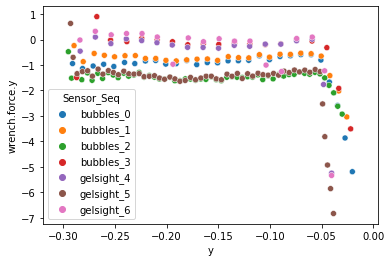

In [489]:
sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [490]:
steady_data = df_out[(df_out[x_key] < x_range_ss[1]) & (df_out[x_key] > x_range_ss[0]) ]

unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
means = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_ss = steady_data[steady_data.Sensor_Seq == sensor_seq_i] 
    means[sensor_seq_i] = np.mean(sensor_ss[y_key])

In [491]:
df_out['steady_value'] = df_out['Sensor_Seq'].map(means)
df_out['{}_norm'.format(y_key)] = df_out['steady_value'] - df_out[y_key]

df_norm = df_out[(df_out[x_key] < x_range[1]) & (df_out[x_key] > x_range[0]) ]


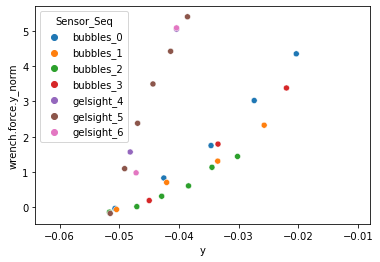

In [492]:
ax = sns.scatterplot(x=x_key, y='{}_norm'.format(y_key), data=df_norm, hue='Sensor_Seq')

(-0.08, 0.0)

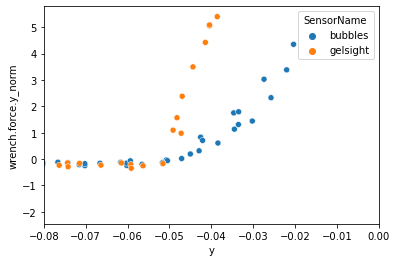

In [493]:
ax = sns.scatterplot(x=x_key, y='{}_norm'.format(y_key), data=df_out, hue='SensorName')
ax.set_xlim([-0.08, 0.])

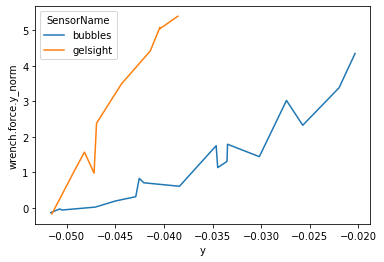

In [494]:
ax = sns.lineplot(x='y', y='{}_norm'.format(y_key), data=df_norm, hue='SensorName', ci='sd')

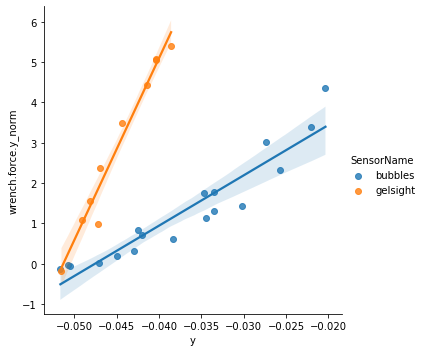

In [495]:
ax = sns.lmplot(x='y', y='{}_norm'.format(y_key), data=df_norm, hue='SensorName')

gelsight_5 [[427.33863516]] [0.06290518]
bubbles_2 [[76.72056767]] [-0.27191394]


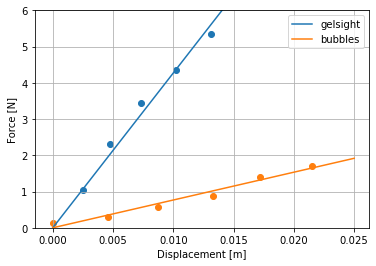

In [496]:
df_norm_f = df_norm.copy()
df_norm_f['{}_norm'.format(x_key)] = df_norm_f['{}'.format(x_key)] - np.min(df_norm_f['{}'.format(x_key)].values)
ax, regs = regression_plots(df_norm_f, ['gelsight_5', 'bubbles_2'], 0.025, {'gelsight_5': 'gelsight', 'bubbles_2':'bubbles'})
ax.set_ylim(0,6)
ax.set_xlabel('Displacement [m]')
ax.set_ylabel('Force [N]')
ax.grid()
for k, reg_i in regs.items():
    print(k, reg_i.coef_, reg_i.intercept_)

In [498]:
# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight_sideways.svg'))